# Image Segmentation

## Introduction

This project aims to develop an image segmentation model that can accurately identify cars and people in pictures using PyTorch and OpenCV libraries. 

Image segmentation is the process of dividing an image into multiple segments or regions, each of which corresponds to a different object or part of the image. This model will be trained on a dataset of images that contains cars and people, and will use a combination of deep learning techniques and computer vision algorithms to segment the objects in the images. 

The goal of this project is to develop a model that can accurately identify cars and people in pictures with a high level of precision and recall. The Pytorch library is used as the main deep learning library, and OpenCV is used for image processing and manipulation.



### References

* https://www.kaggle.com/code/sudhupandey/cityscape-segmentation-unet-pytorch
* https://www.youtube.com/watch?v=aMldpZF6GBU
* https://www.kaggle.com/code/gokulkarthik/image-segmentation-with-unet-pytorch

## Dataset Loading & Data Exploration & Preprocessing

In [1]:
from utils import MyDataset

from glob import glob
from torch.utils.data import DataLoader
import torchvision.transforms as transform

In [2]:
train_path = glob('../data/train/*.jpg')
valid_path = glob('../data/val/*.jpg')

PyTorch Vision Transforms is a module in the PyTorch library that provides a set of pre-defined image and video transformations that can be applied to the input data before it is fed into a neural network.
In our case we will use ToTensor transform which transforms our input images into pytorch tensros.

In [3]:
mytransformsImage = transform.Compose(
    [
        transform.ToTensor()
    ]
)

mytransformsLabel = transform.Compose(
    [
        transform.ToTensor(),
    ]
)

In [4]:
traindata = MyDataset(train_path, mytransformsImage, mytransformsLabel)
valdata = MyDataset(valid_path, mytransformsImage, mytransformsLabel)

In [5]:
batch_size = 4
train_loader = DataLoader(traindata,batch_size)
vaild_loader = DataLoader(valdata,1)

More [Here](Dataset&#32;Preparation.ipynb)

## Modelization

In this project, we will be using the U-Net architecture, which is a popular deep learning architecture for image segmentation tasks. U-Net was developed specifically for medical image segmentation, but it has also been applied to other domains such as remote sensing, industrial inspection, and self-driving cars. 

U-Net architecture is known for its ability to handle small, noisy and highly imbalanced datasets, making it an ideal choice for this project. The U-Net architecture uses a combination of convolutional and pooling layers to extract features from the input images, and a series of upsampling and concatenation layers to produce the final segmentation map. The architecture also has a high level of flexibility and can be adapted to different image sizes and numbers of classes.

In [6]:
%matplotlib inline

from utils import UNet

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2

import joblib
import torch
from torch import nn

In [7]:
def show(img,output,label,denorm = False):
    img,output,label = img.cpu(),output.cpu(),label.cpu()
    fig,ax = plt.subplots(len(output),3,figsize=(10,10))
    
    for i in range(len(output)):
        if(len(output) == 3):
            Img,Lab,act = img[i],output[i],label[i]
            Img,Lab,act = Img,Lab.detach().permute(1,2,0).numpy(),act
            ax[i][0].imshow(Img.permute(1,2,0))
            ax[i][1].imshow(Lab)
            ax[i][2].imshow(act.permute(1,2,0))
        else:
            Img,Lab,act = img[i],output[i],label[i]
            Img,Lab,act = Img,Lab.detach().permute(1,2,0).numpy(),act
            ax[0].imshow(Img.permute(1,2,0))
            ax[1].imshow(Lab)
            ax[2].imshow(act.permute(1,2,0))
    plt.show()

Wee will check if cuda is available with torch, in order to use GPU for training and inference.
In my case, I installed pytorch with cuda to make training faster.

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device {device}')

Device cuda


We will declare the model.
The input parameter 3 is the input_channel, i.e. the number of colors in the input image. Since we are workning with colored images, we have 3 channels (Red, Green, Blue)

In [9]:
model = UNet(3).float().to(device)

lr=0.01
epochs=5

Next we define our loss function and optimizer.

The loss function is MSE Loss (Mean Squared Error), we will use it to minimize the error between the expected mask and output mask.

The optimizer used is Adam, since it usually gives the fastest conversion in the optimization.

In [10]:
lossfunc = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [11]:
train_loss = []
val_loss = []

In [12]:
def train(epochs):
    for i in range(epochs):
        trainloss = 0
        valloss = 0

        for img,label in tqdm(train_loader):
            '''
            Traning the Model.
            '''
            optimizer.zero_grad()
            img = img.to(device)
            label = label.to(device)
            output = model(img)
            loss = lossfunc(output,label)
            loss.backward()
            optimizer.step()
            trainloss+=loss.item()
            
        if i % 5 == 0:
            show(img,output,label)

        train_loss.append(trainloss/len(train_loader))    

        for img,label in tqdm(vaild_loader):
            '''
            Validation of Model.
            '''
            img = img.to(device)
            label = label.to(device)
            output = model(img)
            loss = lossfunc(output,label)
            valloss+=loss.item()

        val_loss.append(valloss/len(vaild_loader))  

        print("epoch : {} ,train loss : {} ,valid loss : {} ".format(i,train_loss[-1],val_loss[-1]))

The function train, takes as input the number of epochs, and trains the model for the specified number of epochs.

  0%|          | 0/744 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


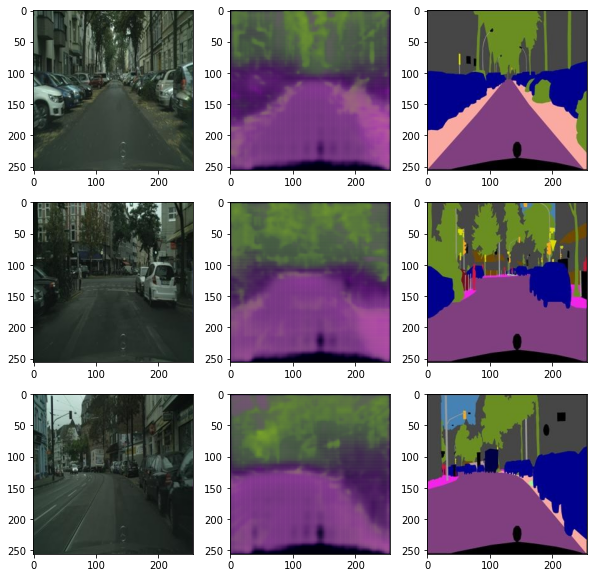

  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0 ,train loss : 0.029435467187775878 ,valid loss : 0.02963928819820285 


In [28]:
train(1)

To save the model checkpoint : `torch.save(model.state_dict(), '../artifacts/model.pt')`

### Checkpoint Model

I trained a model for 30 epochs, I will now load the model and the train and validation losses. 

In [13]:
model = UNet(3).float().to('cuda')
model.load_state_dict(torch.load('../artifacts/model.pt'))
model.eval()

UNet(
  (conv1): Convblock(
    (convblock): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (4): ReLU(inplace=True)
    )
  )
  (conv2): Convblock(
    (convblock): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (4): ReLU(inplace=True)
    )
  )
  (conv3): Convblock(
    (convblock): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 

In [14]:
train_loss = joblib.load('../artifacts/train_loss.arr')
val_loss = joblib.load('../artifacts/val_loss.arr')

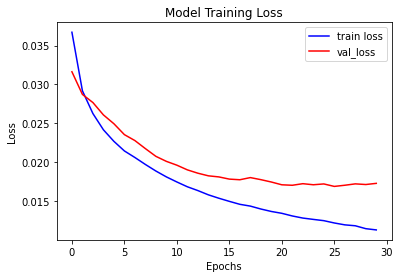

In [15]:
plt.plot(train_loss,color='b',label='train loss')
plt.plot(val_loss,color='r',label = 'val_loss')
plt.legend()
plt.title('Model Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show();

## Performances evaluation

We can see the train and validation losses going down as the number of epochs spent in training increases.

Train Loss keeps decreasing, however the validation loss after around 15 epochs stays almost fix, meaning our model is in overfitting, and training for more epochs will not improve the performance anymore.

## Inference

Next step is using the model, in order to get the mask for people and cars in the images.

C:\Users\elies\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torchvision\transforms\functional.py:149: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:205.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Mask')

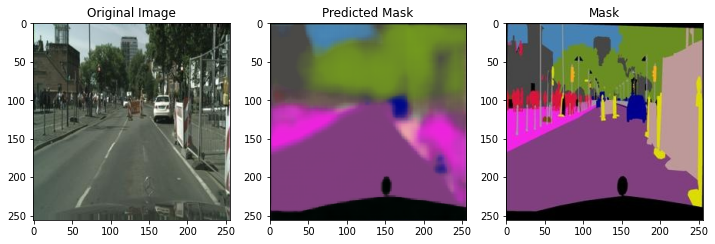

In [16]:
def get_mask(model, path):
    # Read the image from the path
    img = plt.imread(path)
    
    # Split the image into image and mask 
    img,label = img[:,:int(img.shape[1]/2)],img[:,int(img.shape[1]/2):]
    
    # Apply transformation
    image = mytransformsImage(img).unsqueeze(0).to(device)
    out = model(image)
    out = out.cpu()[0].detach().permute(1,2,0).numpy()
    out = (out * 255).astype(int)

    return img, out, label
    
img, out, label = get_mask(model, '../data/val/100.jpg')

fig,ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[1].imshow(out)
ax[1].set_title('Predicted Mask')
ax[2].imshow(label)
ax[2].set_title('Mask')

Next step is isolating the cars and peoples in the predicted masks

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Car Mask')

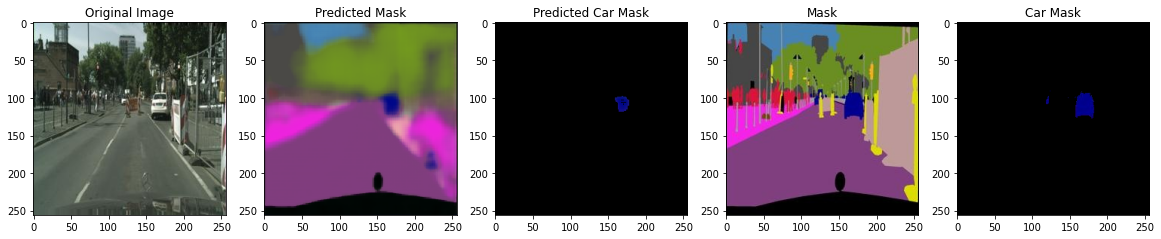

In [17]:
def get_car_mask(img):
    lower_color_bounds = np.array([0, 0, 100])
    upper_color_bounds = np.array([30, 30, 255])
    
    mask = cv2.inRange(img, lower_color_bounds, upper_color_bounds)
    masked = cv2.bitwise_and(img,img, mask=mask)

    return masked
    
car_mask = get_car_mask(label)

fig,ax = plt.subplots(1,5,figsize=(20,8))
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[1].imshow(out)
ax[1].set_title('Predicted Mask')
ax[2].imshow(get_car_mask(out))
ax[2].set_title('Predicted Car Mask')
ax[3].imshow(label)
ax[3].set_title('Mask')
ax[4].imshow(get_car_mask(label))
ax[4].set_title('Car Mask')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Person Mask')

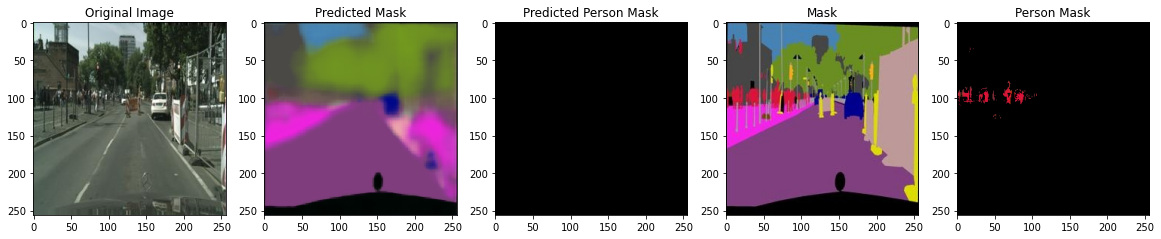

In [18]:
def get_person_mask(img):
    lower_color_bounds = np.array([100, 0, 0])
    upper_color_bounds = np.array([255, 60, 60])
    
    mask = cv2.inRange(img, lower_color_bounds, upper_color_bounds)
    masked = cv2.bitwise_and(img,img, mask=mask)

    return masked
    
car_mask = get_car_mask(label)

fig,ax = plt.subplots(1,5,figsize=(20,8))
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[1].imshow(out)
ax[1].set_title('Predicted Mask')
ax[2].imshow(get_person_mask(out))
ax[2].set_title('Predicted Person Mask')
ax[3].imshow(label)
ax[3].set_title('Mask')
ax[4].imshow(get_person_mask(label))
ax[4].set_title('Person Mask')

The mask results for the cars are more accurate that those for people.

I have different theories as to why:
1. Cars are usually larger than people, which makes identification easier.
2. We have more car samples than peoples in the training set.

## Conclusion

Overall, this project has successfully demonstrated the ability to use deep learning techniques and the U-Net architecture to identify cars and people in pictures. However, it is important to note that the generated masks may not be of the highest quality and there is still room for improvement.

One way to improve the results would be to use a larger and more diverse dataset to train the model. As the model is trained on a limited dataset, it may not be able to generalize well to new images. Additionally, using a dataset that includes images taken from different angles and lighting conditions can make the model more robust to these variations.

Another way to improve the results is to fine-tune the model architecture and hyperparameters. The U-Net architecture has been shown to be effective for image segmentation tasks, but it may not be optimal for this specific task. Experimenting with different architectures and hyperparameters can help to find the best configuration for this project.

Furthermore, data augmentation can also be used to artificially increase the size of the dataset and make the model more robust to variations in the data. Using the Pytorch Vision Transforms module can be a good way to apply various modifications to the input images such as random cropping, flipping, and normalization.

In conclusion, this project has shown the potential of using deep learning techniques for image segmentation tasks, however, there is still room for improvement. By using a larger and more diverse dataset, fine-tuning the model architecture and hyperparameters, and applying data augmentation, it is possible to achieve higher quality results.